# 02 — Shocks (Food price year-to-year changes)

**Dataset (source file):** `raw_data/hdx_hapi_food_price_afg.csv`  
**Website section:** `js/sections/shocks.js`

This notebook:
1) reads raw food price data,
2) keeps only rows with a valid year + valid positive price/value,
3) shows dropped rows,
4) saves cleaned input to `dataset/cleaned/food_price_clean.csv`,
5) computes YoY% change samples and saves them to `dataset/derived/food_price_yoy_samples.csv`.


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

RAW_DIR = Path("raw_data")        # raw inputs live here
DATASET_DIR = Path("dataset")     # website reads from here
CLEAN_DIR = DATASET_DIR / "cleaned"
DERIVED_DIR = DATASET_DIR / "derived"

CLEAN_DIR.mkdir(parents=True, exist_ok=True)
DERIVED_DIR.mkdir(parents=True, exist_ok=True)

def to_number(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s.astype(str).str.replace(",", "").str.strip(), errors="coerce")

def parse_year(val) -> float:
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    if len(s) >= 4 and s[:4].isdigit():
        return float(s[:4])
    for sep in ("/", "-"):
        parts = s.split(sep)
        if len(parts) == 3 and parts[-1].isdigit():
            return float(parts[-1])
    return np.nan

def show_filter_report(df_before: pd.DataFrame, mask: pd.Series, title: str, sample_n: int = 10):
    kept = df_before[mask].copy()
    dropped = df_before[~mask].copy()
    print(f"=== {title} ===")
    print("rows_before:", len(df_before))
    print("rows_kept:", len(kept))
    print("rows_dropped:", len(dropped))
    if len(dropped):
        print("\nSample dropped rows:")
        display(dropped.head(sample_n))
    return kept, dropped


In [8]:

import pandas as pd

df = pd.read_csv("hdx_hapi_food_price_afg.csv")
df.head()




,location_code,has_hrp,in_gho,provider_admin1_name,provider_admin2_name,admin1_code,admin1_name,admin2_code,admin2_name,admin_level,...,lon,commodity_category,commodity_name,unit,price_flag,price_type,currency_code,price,reference_period_start,reference_period_end
0,AFG,True,True,Badakhshan,Argo,AF17,Badakhshan,AF1702,Argo,2,...,70.46,cereals and tubers,Bread,KG,aggregate,Retail,AFN,77.00,2025-01-15,2025-02-14
1,AFG,True,True,Badakhshan,Argo,AF17,Badakhshan,AF1702,Argo,2,...,70.46,cereals and tubers,Rice (high quality),KG,aggregate,Retail,AFN,88.54,2025-01-15,2025-02-14
2,AFG,True,True,Badakhshan,Argo,AF17,Badakhshan,AF1702,Argo,2,...,70.46,cereals and tubers,Rice (low quality),KG,aggregate,Retail,AFN,55.00,2025-01-15,2025-02-14
3,AFG,True,True,Badakhshan,Argo,AF17,Badakhshan,AF1702,Argo,2,...,70.46,cereals and tubers,Wheat,KG,aggregate,Retail,AFN,23.19,2025-01-15,2025-02-14
4,AFG,True,True,Badakhshan,Argo,AF17,Badakhshan,AF1702,Argo,2,...,70.46,cereals and tubers,Wheat flour (high quality),KG,aggregate,Retail,AFN,30.38,2025-01-15,2025-02-14


In [10]:
price_col = "price" if "price" in df.columns else ("value" if "value" in df.columns else None)
assert price_col is not None, "Need a 'price' or 'value' column"

commodity_col = "commodity" if "commodity" in df.columns else ("commodity_name" if "commodity_name" in df.columns else None)
market_col = "market" if "market" in df.columns else ("market_name" if "market_name" in df.columns else None)

df2 = df.copy()
df2["year"] = df2["reference_period_start"].apply(parse_year)
df2["price_num"] = to_number(df2[price_col])

mask = df2["year"].notna() & df2["price_num"].notna() & (df2["price_num"] > 0)
kept, dropped = show_filter_report(df2, mask, "Food price filter (valid year, numeric price/value, price>0)")


=== Food price filter (valid year, numeric price/value, price>0) ===
rows_before: 35046
rows_kept: 35046
rows_dropped: 0


In [12]:
# Save cleaned file used for analysis
clean = kept.copy()
clean["year"] = clean["year"].astype(int)
clean_out = CLEAN_DIR / "food_price_clean.csv"
clean.to_csv(clean_out, index=False)
clean_out


WindowsPath('dataset/cleaned/food_price_clean.csv')

In [14]:
# Build YoY samples like the website:
if commodity_col:
    clean["commodity_key"] = clean[commodity_col].astype(str).str.strip().replace("", "Unknown")
else:
    clean["commodity_key"] = "All"

if market_col:
    clean["market_key"] = clean[market_col].astype(str).str.strip().replace("", "All")
else:
    clean["market_key"] = "All"

clean["series_key"] = clean["commodity_key"] + "||" + clean["market_key"]

yearly = (clean.groupby(["series_key","year"], as_index=False)["price_num"]
            .mean()
            .sort_values(["series_key","year"]))

samples = []
for key, g in yearly.groupby("series_key"):
    g = g.sort_values("year")
    prev = None
    for _, row in g.iterrows():
        if prev is None:
            prev = row
            continue
        if prev["price_num"] > 0:
            pct = ((row["price_num"] - prev["price_num"]) / prev["price_num"]) * 100.0
            if np.isfinite(pct):
                samples.append({"series_key": key, "year": int(row["year"]), "pct_change_yoy": float(pct)})
        prev = row

samples_df = pd.DataFrame(samples)
samples_df.head(), len(samples_df)


(          series_key  year  pct_change_yoy
 0  Bread||Badakhshan  2021       24.431667
 1  Bread||Badakhshan  2022       22.746086
 2  Bread||Badakhshan  2023        0.826049
 3  Bread||Badakhshan  2024        0.002165
 4  Bread||Badakhshan  2025        0.000000,
 2608)

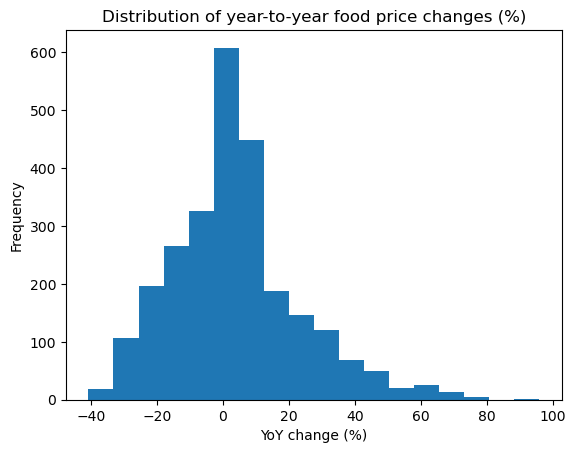

In [16]:
plt.figure()
plt.hist(samples_df["pct_change_yoy"].dropna(), bins=18)
plt.title("Distribution of year-to-year food price changes (%)")
plt.xlabel("YoY change (%)")
plt.ylabel("Frequency")
plt.show()


In [18]:
out_csv = DERIVED_DIR / "food_price_yoy_samples.csv"
samples_df.to_csv(out_csv, index=False)
out_csv


WindowsPath('dataset/derived/food_price_yoy_samples.csv')

In [20]:
dropped_out = CLEAN_DIR / "food_price_dropped.csv"
dropped.to_csv(dropped_out, index=False)
dropped_out


WindowsPath('dataset/cleaned/food_price_dropped.csv')